# От Атлантики до Авиньона: диалог эпох

## Обучение Stable Diffusion на стилях Уинслоу Гомера и Пабло Пикассо

Этот notebook содержит код для обучения двух моделей Stable Diffusion:
1. **Модель Гомера** - для генерации изображений в стиле американского реализма XIX века
2. **Модель Пикассо** - для генерации изображений в кубистическом стиле

### Структура:
1. Установка зависимостей
2. Подготовка данных
3. Обучение модели для стиля Гомера
4. Обучение модели для стиля Пикассо
5. Генерация тестовых изображений
6. Создание финальной серии изображений


# Скачивание данных

In [ ]:
!wget  -O NGA_Dataset.zip

!unzip -q NGA_Dataset.zip

--2025-10-14 13:36:57--  https://github.com/danilpavlov/hse-dl-course/raw/master/project/NGA_Dataset.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/danilpavlov/hse-dl-course/master/project/NGA_Dataset.zip [following]
--2025-10-14 13:36:58--  https://raw.githubusercontent.com/danilpavlov/hse-dl-course/master/project/NGA_Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53090199 (51M) [application/zip]
Saving to: ‘NGA_Dataset.zip’

NGA_Dataset.zip     100%[===================>]  50.63M   229MB/s    in 0.2s    

2025-10-14 13:36:59 (229 MB/s) - ‘NGA_Dataset.zip’ saved [53090199/53090

## 1. Установка зависимостей


In [12]:
# Установка необходимых библиотек для обучения
!pip install -q transformers==4.49 diffusers==0.32.2 accelerate datasets torch torchvision pillow xformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 6.4 MB/s eta 0:00:00


## 2. Подготовка данных

Загружаем и анализируем датасет с картинами Гомера и Пикассо


In [3]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Загружаем описание датасета
description_df = pd.read_csv("NGA_Dataset/description.csv")

print(f"Всего изображений: {len(description_df)}")
print("\nРаспределение по художникам:")
print(description_df['artist'].value_counts())


print("\nПримеры из датасета:")
print(description_df[['filename', 'artist', 'title', 'date']].head(10))


Всего изображений: 31

Распределение по художникам:
artist
Picasso, Pablo    17
Homer, Winslow    14
Name: count, dtype: int64

Примеры из датасета:
                                   filename          artist  \
0  1155a052-5f8d-4168-80dc-750ca9c5e497.jpg  Homer, Winslow   
1  1f56dea6-546c-4576-9596-0bf20f1c60e5.jpg  Homer, Winslow   
2  26833f2a-be4f-43cc-9216-b226c37557a3.jpg  Picasso, Pablo   
3  2308ad47-a890-44b1-a1a9-e6c834d598bc.jpg  Picasso, Pablo   
4  3d26f129-aa76-4f97-b64d-bc0d4157207c.jpg  Homer, Winslow   
5  45bad99c-e7c3-49bc-be81-dc1baccaef48.jpg  Homer, Winslow   
6  452e1836-9785-498f-a202-0fae2ddea167.jpg  Homer, Winslow   
7  406b5d56-d196-4bb0-b2e0-5a2f6fd52d0a.jpg  Homer, Winslow   
8  4e2c5d2f-48a5-4119-a0ad-65b7f8e13b85.jpg  Homer, Winslow   
9  600fb1fc-c22e-4cb1-a6c1-74044a9fc705.jpg  Homer, Winslow   

                                           title       date  
0                               Home, Sweet Home    c. 1863  
1                       Sketch of

In [4]:
# Разделяем данные по художникам
homer_df = description_df[description_df['artist'].str.contains('Homer', case=False, na=False)]
picasso_df = description_df[description_df['artist'].str.contains('Picasso', case=False, na=False)]

print(f"Изображений Гомера: {len(homer_df)}")
print(f"Изображений Пикассо: {len(picasso_df)}")

# Создаём директории для раздельных датасетов (для удобства)
os.makedirs("dataset_homer", exist_ok=True)
os.makedirs("dataset_picasso", exist_ok=True)

# Копируем изображения Гомера
for filename in homer_df['filename']:
    src = os.path.join("NGA_Dataset", filename)
    dst = os.path.join("dataset_homer", filename)
    if os.path.exists(src) and not os.path.exists(dst):
        import shutil
        shutil.copy(src, dst)

# Копируем изображения Пикассо
for filename in picasso_df['filename']:
    src = os.path.join("NGA_Dataset", filename)
    dst = os.path.join("dataset_picasso", filename)
    if os.path.exists(src) and not os.path.exists(dst):
        import shutil
        shutil.copy(src, dst)

print(f"\nДатасеты готовы!")
print(f"dataset_homer/: {len(os.listdir('dataset_homer'))} файлов")
print(f"dataset_picasso/: {len(os.listdir('dataset_picasso'))} файлов")


Изображений Гомера: 14
Изображений Пикассо: 17

Датасеты готовы!
dataset_homer/: 14 файлов
dataset_picasso/: 17 файлов


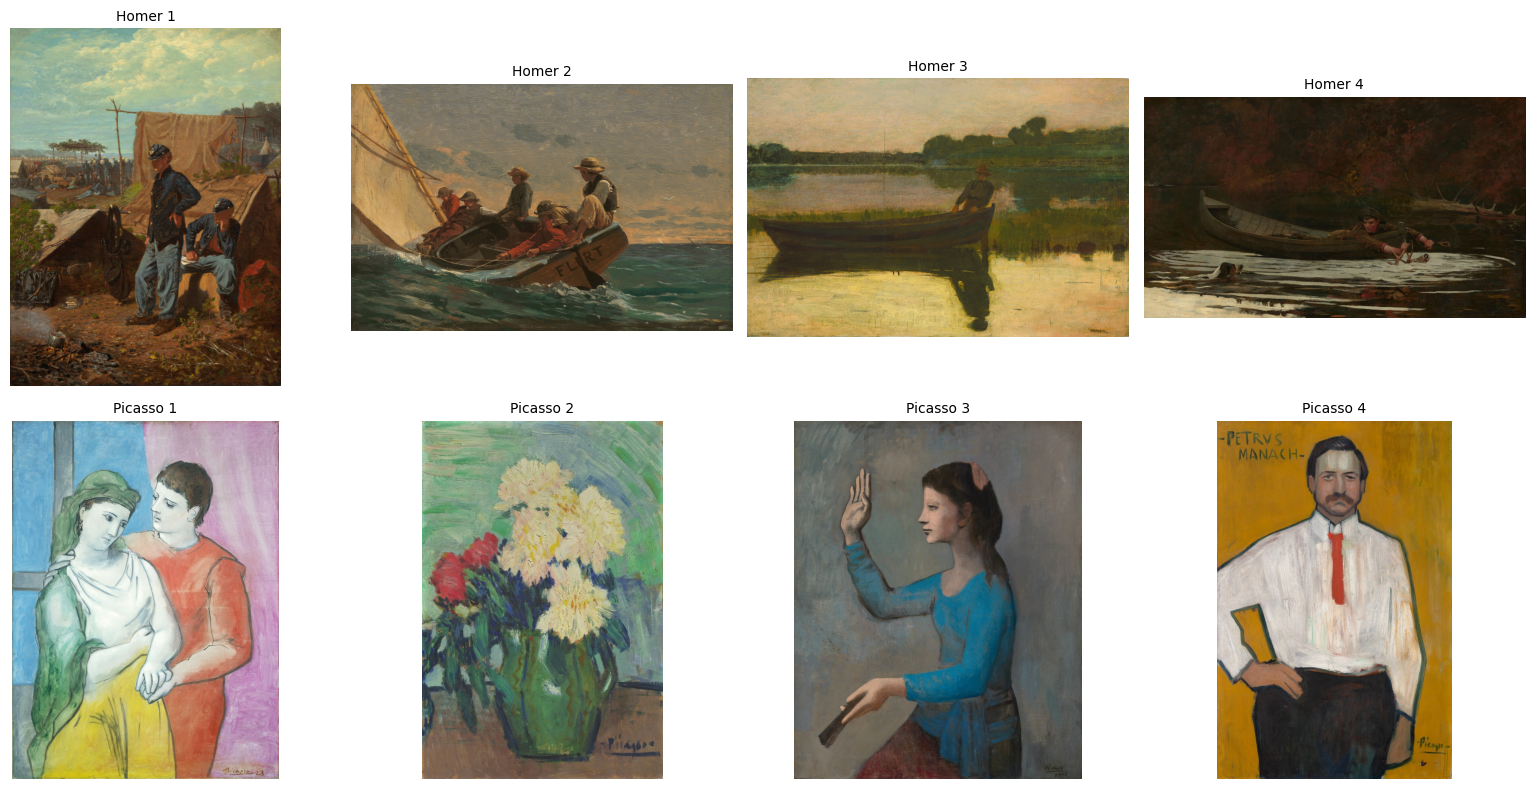

In [5]:
import os

# Создаем директорию ассетов если нет
if not os.path.exists('./assets'):
    os.makedirs("./assets")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Примеры Гомера
homer_files = os.listdir('dataset_homer')[:4]
for idx, filename in enumerate(homer_files):
    img = Image.open(os.path.join('dataset_homer', filename))
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'Homer {idx+1}', fontsize=10)
    axes[0, idx].axis('off')

# Примеры Пикассо
picasso_files = os.listdir('dataset_picasso')[:4]
for idx, filename in enumerate(picasso_files):
    img = Image.open(os.path.join('dataset_picasso', filename))
    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f'Picasso {idx+1}', fontsize=10)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('assets/dataset_examples.png', dpi=150, bbox_inches='tight')
plt.show()


## 3. Подготовка модели и датасета для обучения

Создаём класс датасета и загружаем базовую модель Stable Diffusion


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm


# Класс датасета с произведениями артиста
class ArtistDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir

        # Берем только изображения
        self.image_paths = [os.path.join(image_dir, fname)
                           for fname in os.listdir(image_dir)
                           if fname.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image}


In [13]:
# Установка дополнительных оптимизаций
import gc
import torch
import os
from typing import Dict, Optional, Tuple
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

# Функция для очистки памяти
def cleanup_memory():
    """Очищает GPU память"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# Функция для загрузки компонентов Stable Diffusion
def load_sd_components(
    model_id: str = "runwayml/stable-diffusion-v1-5",
    device: str = "cuda",
    dtype: torch.dtype = torch.float16,
    load_safety_checker: bool = False
) -> Dict:
    """
    Загружает все компоненты Stable Diffusion

    Args:
        model_id: ID модели на HuggingFace
        device: устройство для загрузки (cuda/cpu)
        dtype: тип данных (float16/float32)
        load_safety_checker: загружать ли safety checker

    Returns:
        Словарь с компонентами модели
    """
    print(f"Загрузка компонентов из {model_id}...")

    # Загрузка токенизатора
    tokenizer = CLIPTokenizer.from_pretrained(
        model_id,
        subfolder="tokenizer"
    )

    # Загрузка text encoder
    text_encoder = CLIPTextModel.from_pretrained(
        model_id,
        subfolder="text_encoder",
        torch_dtype=dtype
    ).to(device)

    # Загрузка UNet
    unet = UNet2DConditionModel.from_pretrained(
        model_id,
        subfolder="unet",
        torch_dtype=dtype
    ).to(device)

    # Загрузка VAE через pipeline для правильной инициализации
    vae = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=dtype
    ).vae.to(device)

    # Загрузка noise scheduler
    noise_scheduler = DDPMScheduler.from_pretrained(
        model_id,
        subfolder="scheduler"
    )

    components = {
        "tokenizer": tokenizer,
        "text_encoder": text_encoder,
        "unet": unet,
        "vae": vae,
        "noise_scheduler": noise_scheduler
    }

    # Опционально загружаем safety checker
    if load_safety_checker:
        from transformers import AutoFeatureExtractor
        safety_checker = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=dtype
        ).safety_checker
        feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

        components["safety_checker"] = safety_checker
        components["feature_extractor"] = feature_extractor

    print("✓ Компоненты загружены")
    return components

# Функция для применения оптимизаций к моделям
def apply_model_optimizations(
    components: Dict,
    enable_gradient_checkpointing: bool = True,
    enable_xformers: bool = True,
    enable_cpu_offload: bool = False,
    freeze_vae: bool = True,
    freeze_text_encoder: bool = True
) -> Dict:
    """
    Применяет различные оптимизации к компонентам модели

    Args:
        components: словарь с компонентами модели
        enable_gradient_checkpointing: включить gradient checkpointing
        enable_xformers: включить xFormers
        enable_cpu_offload: включить CPU offload
        freeze_vae: заморозить веса VAE
        freeze_text_encoder: заморозить веса text encoder

    Returns:
        Обновленный словарь компонентов
    """
    unet = components["unet"]
    text_encoder = components["text_encoder"]
    vae = components["vae"]

    # Gradient checkpointing
    if enable_gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if hasattr(text_encoder, 'gradient_checkpointing_enable'):
            text_encoder.gradient_checkpointing_enable()
        print("✓ Gradient checkpointing включен")

    # xFormers оптимизация
    if enable_xformers:
        try:
            unet.enable_xformers_memory_efficient_attention()
            print("✓ xFormers включен для эффективного внимания")
        except Exception as e:
            print(f"⚠ xFormers недоступен: {e}")
            # Пробуем альтернативный efficient attention
            try:
                from diffusers.models.attention_processor import AttnProcessor2_0
                unet.set_attn_processor(AttnProcessor2_0())
                print("✓ Использован AttnProcessor2_0 вместо xFormers")
            except:
                print("⚠ Используется стандартное внимание")

    # CPU offload для экономии GPU памяти
    if enable_cpu_offload:
        unet.enable_sequential_cpu_offload()
        print("✓ CPU offload включен")

    # Заморозка весов для экономии памяти
    if freeze_vae:
        vae.requires_grad_(False)
        vae.eval()
        print("✓ VAE заморожен")

    if freeze_text_encoder:
        text_encoder.requires_grad_(False)
        text_encoder.eval()
        print("✓ Text encoder заморожен")

    return components

# Функция для создания и сохранения pipeline
def create_and_save_pipeline(
    components: Dict,
    output_dir: str,
    enable_xformers: bool = True
) -> StableDiffusionPipeline:
    """
    Создает полный pipeline и сохраняет его

    Args:
        components: словарь с компонентами модели
        output_dir: директория для сохранения
        enable_xformers: включить xFormers в финальном pipeline

    Returns:
        Готовый pipeline
    """
    # Создание pipeline
    pipeline = StableDiffusionPipeline(
        vae=components["vae"],
        text_encoder=components["text_encoder"],
        tokenizer=components["tokenizer"],
        unet=components["unet"],
        scheduler=components["noise_scheduler"],
        safety_checker=components.get("safety_checker", None),
        feature_extractor=components.get("feature_extractor", None),
        requires_safety_checker=False,
    )

    # Включаем оптимизации в финальном pipeline
    if enable_xformers:
        try:
            pipeline.enable_xformers_memory_efficient_attention()
        except:
            pass

    # Сохранение
    os.makedirs(output_dir, exist_ok=True)
    pipeline.save_pretrained(output_dir)
    print(f"✓ Pipeline сохранен в {output_dir}")

    return pipeline

# Функция для настройки тренировочного цикла
def setup_training(
    components: Dict,
    learning_rate: float = 1e-5,
    max_train_steps: int = 300,
    gradient_accumulation_steps: int = 8,
    mixed_precision: str = "fp16",
    warmup_steps: int = 50
) -> Tuple[Accelerator, torch.optim.Optimizer, object]:
    """
    Настраивает компоненты для обучения

    Returns:
        Tuple из (accelerator, optimizer, lr_scheduler)
    """
    # Инициализация Accelerator
    accelerator = Accelerator(
        mixed_precision=mixed_precision,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    # Оптимизатор
    optimizer = torch.optim.AdamW(
        components["unet"].parameters(),
        lr=learning_rate,
        betas=(0.9, 0.999),
        weight_decay=0.01,
        eps=1e-08
    )

    # Планировщик обучения
    lr_scheduler = get_scheduler(
        "cosine",
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=max_train_steps * gradient_accumulation_steps,
    )

    return accelerator, optimizer, lr_scheduler

print("✓ Вспомогательные функции для загрузки моделей готовы!")

# Оптимизированная функция обучения (использует модульные функции)
def train_model_optimized(dataset_dir, output_dir, artist_name,
                         resolution=384,  # Уменьшено с 512
                         batch_size=1,
                         learning_rate=1e-5,
                         num_epochs=3,
                         max_train_steps=300,
                         use_xformers=True,
                         mixed_precision="fp16",
                         gradient_checkpointing=True,
                         model_id="runwayml/stable-diffusion-v1-5"):
    """
    Оптимизированная версия обучения с низким потреблением памяти
    Использует модульные функции для загрузки и настройки моделей
    """

    print(f"="*60)
    print(f"Начало оптимизированного обучения модели для стиля {artist_name}")
    print(f"="*60)

    # Параметры обучения
    gradient_accumulation_steps = 8  # Увеличено для меньшего потребления памяти
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if mixed_precision == "fp16" else torch.float32

    # Преобразования для изображений
    transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

    # Загрузка данных
    dataset = ArtistDataset(dataset_dir, transform=transform)
    print(f"Размер датасета: {len(dataset)} изображений")
    print(f"Разрешение: {resolution}x{resolution}")
    print(f"Mixed precision: {mixed_precision}")
    print(f"Gradient checkpointing: {gradient_checkpointing}")

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=False,  # Отключено для экономии памяти
        num_workers=0  # Уменьшено для экономии памяти
    )

    # Загрузка компонентов модели с помощью модульной функции
    components = load_sd_components(
        model_id=model_id,
        device=device,
        dtype=dtype,
        load_safety_checker=False
    )

    # Применение оптимизаций
    components = apply_model_optimizations(
        components,
        enable_gradient_checkpointing=gradient_checkpointing,
        enable_xformers=use_xformers,
        enable_cpu_offload=False,
        freeze_vae=True,
        freeze_text_encoder=True
    )

    # Настройка обучения
    accelerator, optimizer, lr_scheduler = setup_training(
        components,
        learning_rate=learning_rate,
        max_train_steps=max_train_steps,
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=mixed_precision,
        warmup_steps=50
    )

    # Извлечение компонентов для удобства
    unet = components["unet"]
    vae = components["vae"]
    text_encoder = components["text_encoder"]
    tokenizer = components["tokenizer"]
    noise_scheduler = components["noise_scheduler"]

    # Подготовка через Accelerator
    unet, optimizer, dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, dataloader, lr_scheduler
    )

    # VAE и text_encoder уже на устройстве благодаря load_sd_components

    # Обучение
    progress_bar = tqdm(range(max_train_steps))
    progress_bar.set_description("Steps")

    global_step = 0

    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch + 1}/{num_epochs}")

        for step, batch in enumerate(dataloader):
            if global_step >= max_train_steps:
                break

            # Конвертация изображений в латенты
            with torch.no_grad():
                pixel_values = batch["pixel_values"].to(accelerator.device, dtype=vae.dtype)
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * 0.18215

            # Генерация случайного шума
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]

            # Выбор случайных временных шагов
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Добавление шума к латентам
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Получение скрытых состояний текста
            with torch.no_grad():
                dummy_prompt = [""] * bsz
                input_ids = tokenizer(
                    dummy_prompt,
                    padding="max_length",
                    truncation=True,
                    max_length=tokenizer.model_max_length,
                    return_tensors="pt",
                ).input_ids.to(accelerator.device)
                encoder_hidden_states = text_encoder(input_ids)[0]

            # Прогнозирование шума
            with accelerator.accumulate(unet):
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

                # Backward pass
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Очистка памяти после каждого шага
            del pixel_values, latents, noise, noisy_latents, noise_pred, encoder_hidden_states
            cleanup_memory()

            # Обновление прогресса
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                avg_loss = accelerator.gather(loss.repeat(batch_size)).mean()
                progress_bar.set_postfix(loss=avg_loss.item(), lr=lr_scheduler.get_last_lr()[0])

                # Сохранение контрольной точки каждые 100 шагов
                if global_step % 100 == 0:
                    if accelerator.is_main_process:
                        checkpoint_dir = f"{output_dir}-checkpoint-{global_step}"
                        accelerator.save_state(checkpoint_dir)
                        print(f"\nКонтрольная точка сохранена: {checkpoint_dir}")

        # Очистка памяти после эпохи
        cleanup_memory()

    # Финальное сохранение модели
    accelerator.wait_for_everyone()

    if accelerator.is_main_process:
        # Обновляем components с обученным UNet
        unwrapped_unet = accelerator.unwrap_model(unet)
        components["unet"] = unwrapped_unet

        # Создаем и сохраняем pipeline с помощью модульной функции
        pipeline = create_and_save_pipeline(
            components,
            output_dir,
            enable_xformers=use_xformers
        )

        # Финальная очистка
        cleanup_memory()

        return pipeline

    return None

print("✓ Оптимизированная функция обучения готова!")


✓ Вспомогательные функции для загрузки моделей готовы!
✓ Оптимизированная функция обучения готова!


In [14]:
# Утилиты для мониторинга памяти и производительности

def get_gpu_memory_info():
    """Показывает информацию об использовании GPU памяти"""
    if torch.cuda.is_available():
        # Текущее использование
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3

        # Максимальное использование
        max_allocated = torch.cuda.max_memory_allocated() / 1024**3
        max_reserved = torch.cuda.max_memory_reserved() / 1024**3

        # Общая память GPU
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3

        print(f"GPU Memory Status:")
        print(f"  Total:         {total:.2f} GB")
        print(f"  Allocated:     {allocated:.2f} GB ({allocated/total*100:.1f}%)")
        print(f"  Reserved:      {reserved:.2f} GB ({reserved/total*100:.1f}%)")
        print(f"  Free:          {total - reserved:.2f} GB")
        print(f"  Max Allocated: {max_allocated:.2f} GB")
        print(f"  Max Reserved:  {max_reserved:.2f} GB")

        return {
            "total": total,
            "allocated": allocated,
            "reserved": reserved,
            "free": total - reserved
        }
    else:
        print("GPU не доступен")
        return None

def estimate_batch_size(resolution=384, model_type="fp16"):
    """
    Оценивает оптимальный размер батча для заданного разрешения

    Args:
        resolution: разрешение изображения
        model_type: "fp16" или "fp32"

    Returns:
        Рекомендуемый размер батча
    """
    if not torch.cuda.is_available():
        return 1

    # Получаем доступную память
    memory_info = get_gpu_memory_info()
    if memory_info is None:
        return 1

    free_memory = memory_info["free"]

    # Оценка использования памяти (приблизительная)
    # Базовое использование модели
    base_memory = 4.5 if model_type == "fp16" else 9.0  # GB

    # Память на одно изображение (приблизительно)
    memory_per_image = {
        256: 0.5 if model_type == "fp16" else 1.0,
        384: 1.2 if model_type == "fp16" else 2.4,
        512: 2.0 if model_type == "fp16" else 4.0,
    }.get(resolution, 2.0)

    # Вычисляем максимальный размер батча
    available_for_batch = free_memory - base_memory - 1.0  # Оставляем 1GB запаса
    if available_for_batch <= 0:
        return 1

    max_batch_size = int(available_for_batch / memory_per_image)

    print(f"\nРекомендуемый размер батча для {resolution}x{resolution} ({model_type}):")
    print(f"  Доступная память: {free_memory:.2f} GB")
    print(f"  Память на изображение: ~{memory_per_image:.2f} GB")
    print(f"  Рекомендуемый batch_size: {max(1, max_batch_size)}")

    return max(1, max_batch_size)

def optimize_for_memory_limit(memory_limit_gb=15):
    """
    Возвращает оптимальные параметры для заданного лимита памяти (Gi)

    Args:
        memory_limit_gb: доступная память GPU в GB

    Returns:
        Словарь с рекомендуемыми параметрами
    """
    if memory_limit_gb >= 24:
        return {
            "resolution": 512,
            "batch_size": 4,
            "gradient_accumulation_steps": 1,
            "mixed_precision": "fp16",
            "gradient_checkpointing": False,
            "description": "Полные настройки для GPU 24GB+"
        }
    elif memory_limit_gb >= 16:
        return {
            "resolution": 512,
            "batch_size": 1,
            "gradient_accumulation_steps": 4,
            "mixed_precision": "fp16",
            "gradient_checkpointing": True,
            "description": "Оптимизированные настройки для GPU 16GB"
        }
    elif memory_limit_gb >= 12:
        return {
            "resolution": 384,
            "batch_size": 1,
            "gradient_accumulation_steps": 8,
            "mixed_precision": "fp16",
            "gradient_checkpointing": True,
            "description": "Сбалансированные настройки для GPU 12-15GB"
        }
    elif memory_limit_gb >= 8:
        return {
            "resolution": 256,
            "batch_size": 1,
            "gradient_accumulation_steps": 16,
            "mixed_precision": "fp16",
            "gradient_checkpointing": True,
            "description": "Минимальные настройки для GPU 8-11GB"
        }
    else:
        return {
            "resolution": 256,
            "batch_size": 1,
            "gradient_accumulation_steps": 32,
            "mixed_precision": "fp16",
            "gradient_checkpointing": True,
            "description": "Ультра-легкие настройки для GPU < 8GB"
        }

# Пример использования
print("="*60)
print("Анализ GPU и рекомендации")
print("="*60)

# Информация о памяти
get_gpu_memory_info()

# Рекомендации для вашего GPU
if torch.cuda.is_available():
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    recommendations = optimize_for_memory_limit(total_memory)

    print(f"\n🎯 Рекомендуемые параметры для вашего GPU ({total_memory:.1f} GB):")
    print(f"  {recommendations['description']}")
    print(f"  - Разрешение: {recommendations['resolution']}x{recommendations['resolution']}")
    print(f"  - Batch size: {recommendations['batch_size']}")
    print(f"  - Gradient accumulation: {recommendations['gradient_accumulation_steps']}")
    print(f"  - Mixed precision: {recommendations['mixed_precision']}")
    print(f"  - Gradient checkpointing: {recommendations['gradient_checkpointing']}")


Анализ GPU и рекомендации
GPU Memory Status:
  Total:         14.74 GB
  Allocated:     3.64 GB (24.7%)
  Reserved:      4.08 GB (27.7%)
  Free:          10.67 GB
  Max Allocated: 3.85 GB
  Max Reserved:  4.08 GB

🎯 Рекомендуемые параметры для вашего GPU (14.7 GB):
  Сбалансированные настройки для GPU 12-15GB
  - Разрешение: 384x384
  - Batch size: 1
  - Gradient accumulation: 8
  - Mixed precision: fp16
  - Gradient checkpointing: True


In [15]:
if torch.cuda.is_available():

    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    params = optimize_for_memory_limit(total_memory)

    print(f"\n🚀 Запуск обучения с автоматически подобранными параметрами:")
    print(f"   GPU: {torch.cuda.get_device_name(0)} ({total_memory:.1f} GB)")

    # Обучение модели Гомера с оптимальными параметрами
    homer_pipeline = train_model_optimized(
        dataset_dir="./NGA_Dataset",
        output_dir="./output",
        artist_name="Winslow Homer",
        resolution=params["resolution"],
        batch_size=params["batch_size"],
        learning_rate=1e-5,
        num_epochs=3,
        max_train_steps=300,
        use_xformers=True,
        mixed_precision=params["mixed_precision"],
        gradient_checkpointing=params["gradient_checkpointing"]
    )
else:
    raise RuntimeError(
        "⚠️ GPU не обнаружен. Используйте Colab/Kaggle с GPU"
    )


🚀 Запуск обучения с автоматически подобранными параметрами:
   GPU: Tesla T4 (14.7 GB)
Начало оптимизированного обучения модели для стиля Winslow Homer
Размер датасета: 31 изображений
Разрешение: 384x384
Mixed precision: fp16
Gradient checkpointing: True
Загрузка компонентов из runwayml/stable-diffusion-v1-5...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✓ Компоненты загружены
✓ Gradient checkpointing включен
⚠ xFormers недоступен: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
✓ Использован AttnProcessor2_0 вместо xFormers
✓ VAE заморожен
✓ Text encoder заморожен


  0%|          | 0/300 [00:00<?, ?it/s]


Эпоха 1/3


ValueError: Attempting to unscale FP16 gradients.

In [ ]:
import gc
import torch

del

gc.collect()
torch.cuda.empty_cache()